In [ ]:
#AUC - PR
#Encotrar modelos pre-treinados que relacionam o problema e treinar com os pesos

In [ ]:
import keras
from keras import Model, layers
from keras.models import load_model, model_from_json
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import shutil

In [ ]:
from google.colab import userdata
import os
import pandas as pd

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

save_path = "/content/my_datasets"
!mkdir -p {save_path}

!kaggle datasets download -d vinitasilaparasetty/fitzpatrick-classification-by-ethnicity -p {save_path}
!unzip {save_path}/fitzpatrick-classification-by-ethnicity.zip -d {save_path}

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/my_datasets/fairface/fairface/train/79796.jpg  
  inflating: /content/my_datasets/fairface/fairface/train/79822.jpg  
  inflating: /content/my_datasets/fairface/fairface/train/79830.jpg  
  inflating: /content/my_datasets/fairface/fairface/train/79850.jpg  
  inflating: /content/my_datasets/fairface/fairface/train/79851.jpg  
  inflating: /content/my_datasets/fairface/fairface/train/79859.jpg  
  inflating: /content/my_datasets/fairface/fairface/train/79862.jpg  
  inflating: /content/my_datasets/fairface/fairface/train/79867.jpg  
  inflating: /content/my_datasets/fairface/fairface/train/79879.jpg  
  inflating: /content/my_datasets/fairface/fairface/train/79884.jpg  
  inflating: /content/my_datasets/fairface/fairface/train/79894.jpg  
  inflating: /content/my_datasets/fairface/fairface/train/79896.jpg  
  inflating: /content/my_datasets/fairface/fairface/train/79898.jpg  
  inflating: /content/my_datase

In [ ]:
data_dir =  "/content/my_datasets/fairface/fairface"
train_dir = data_dir + "/train"
test_dir = data_dir + "/val"

train_metadata = "/content/my_datasets/fitz_undersampled_train_final.csv"
test_metadata = "/content/my_datasets/fitz_undersampled_test_final.csv"

In [ ]:
train_annotations = pd.read_csv(train_metadata)
test_annotations = pd.read_csv(test_metadata)

train_annotations.head()

,file,age,gender,race,phototype
0,1.jpg,50-59,Male,East Asian,III
1,10.jpg,30-39,Male,Middle Eastern,V
2,100.jpg,20-29,Female,East Asian,III
3,1000.jpg,30-39,Male,White,I & II
4,10004.jpg,40-49,Male,Indian,V


In [ ]:
classes = train_annotations['phototype'].unique()
classes

array(['III', 'V', 'I & II', 'IV', 'VI'], dtype=object)

In [ ]:
for phototype in classes:
    os.makedirs(os.path.join(train_dir, phototype), exist_ok=True)

for phototype in classes:
    os.makedirs(os.path.join(test_dir, phototype), exist_ok=True)

In [ ]:
for _, row in train_annotations.iterrows():
    image_file = row['file']
    phototype = row['phototype']
    source_path = os.path.join(train_dir, image_file)
    target_path = os.path.join(train_dir, phototype, image_file)

    if os.path.exists(source_path):
        shutil.move(source_path, target_path)

In [ ]:
for _, row in test_annotations.iterrows():
    image_file = row['file']
    phototype = row['phototype']
    source_path = os.path.join(test_dir, image_file)
    target_path = os.path.join(test_dir, phototype, image_file)

    if os.path.exists(source_path):
        shutil.move(source_path, target_path)

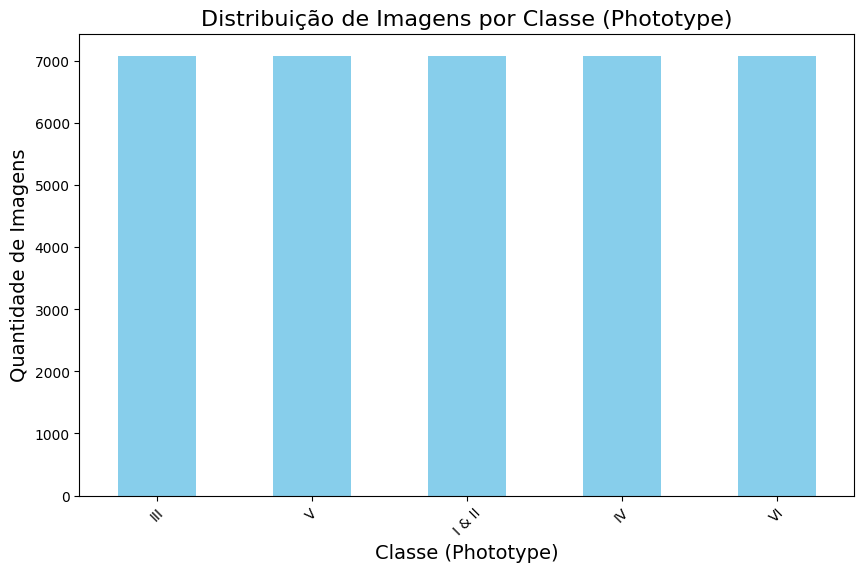

In [ ]:
# Carregar os metadados (train_annotations já foi carregado anteriormente)
# Supondo que a coluna 'phototype' contém a classe de cada imagem
class_counts = train_annotations['phototype'].value_counts()

# Criar o histograma
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')

# Adicionar títulos e rótulos aos eixos
plt.title('Distribuição de Imagens por Classe (Phototype)', fontsize=16)
plt.xlabel('Classe (Phototype)', fontsize=14)
plt.ylabel('Quantidade de Imagens', fontsize=14)

# Exibir o gráfico
plt.xticks(rotation=45)  # Gira os rótulos das classes para facilitar a leitura
plt.show()


In [ ]:
batch_size = 32
train_generator = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=batch_size)

Found 35424 files belonging to 5 classes.
Using 28340 files for training.


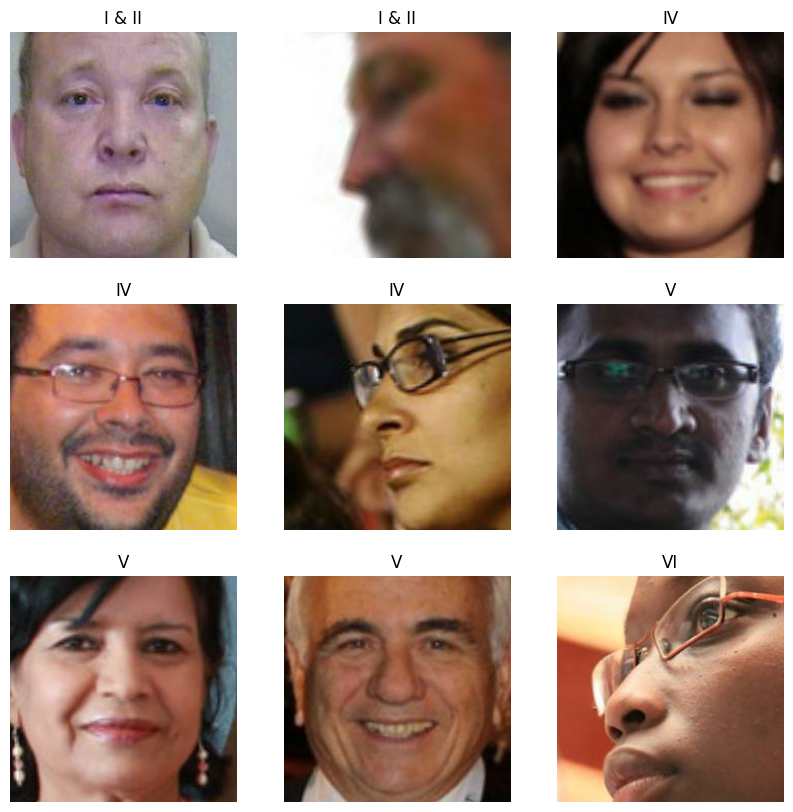

In [ ]:
class_names = train_generator.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_generator.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
validation_generator = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=batch_size)

Found 35424 files belonging to 5 classes.
Using 7084 files for validation.


In [ ]:
test_generator = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=42,
  image_size=(224, 224),
  batch_size=batch_size)

Found 4515 files belonging to 5 classes.


In [ ]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

total_layers = len(base_model.layers)
freeze_layers = int(total_layers * 2 / 3)  # Congelar 2/3 das camadas

for layer in base_model.layers[:freeze_layers]:
    layer.trainable = False

print(freeze_layers)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
116


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 18,069,248 (68.93 MB)

 Non-trainable params: 5,518,464 (21.05 MB)

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.2, 0.2)
])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training=False)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

predictions = layers.Dense(5, activation='softmax')(x)
model = keras.Model(inputs, predictions)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 7, 7, 256)      │      4,718,848 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 7, 7, 256)      │          1,024 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 3, 3, 256)      │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 256)            │              0 │ max_pooling2d[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │         65,792 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_1… │
├──────────────────────

 Total params: 28,375,685 (108.24 MB)

 Trainable params: 22,856,197 (87.19 MB)

 Non-trainable params: 5,519,488 (21.06 MB)

In [ ]:
optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 282s 289ms/step - accuracy: 0.3692 - loss: 1.6627 - val_accuracy: 0.5131 - val_loss: 1.1603 - learning_rate: 0.0010
Epoch 2/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 314s 290ms/step - accuracy: 0.5248 - loss: 1.1720 - val_accuracy: 0.5967 - val_loss: 0.9905 - learning_rate: 0.0010
Epoch 3/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 248s 274ms/step - accuracy: 0.5619 - loss: 1.0722 - val_accuracy: 0.5807 - val_loss: 1.0082 - learning_rate: 0.0010
Epoch 4/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 243s 274ms/step - accuracy: 0.5968 - loss: 1.0123 - val_accuracy: 0.6399 - val_loss: 0.8999 - learning_rate: 0.0010
Epoch 5/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 275s 289ms/step - accuracy: 0.6179 - loss: 0.9626 - val_accuracy: 0.6206 - val_loss: 0.9366 - learning_rate: 0.0010
Epoch 6/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 249s 274ms/step - accuracy: 0.6240 - loss: 0.9409 - val_accuracy: 0.6465 - val_loss: 0.8679 - learning_rate: 0.0010
Epoch 7/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 262s 274ms/step -

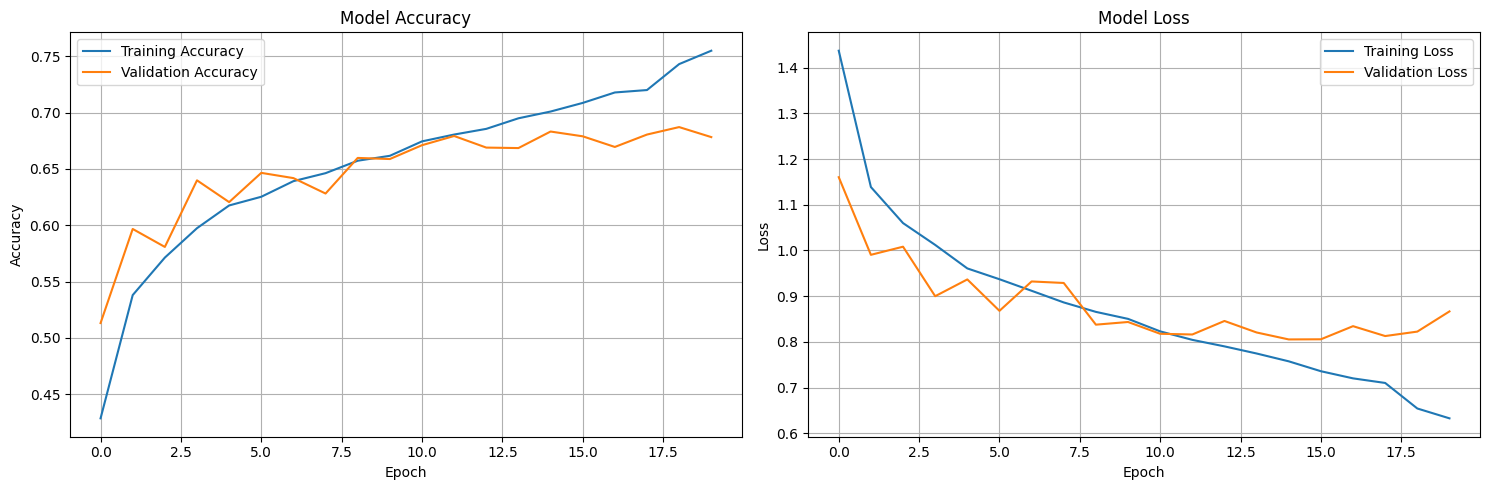

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Usar após o treinamento
plot_training_history(history)

In [ ]:
model.save('/content/model_tom_de_pele.keras')
model_json = model.to_json()
with open("/content/model_tom_de_pele.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("/content/model_tom_de_pele.weights.h5")

In [ ]:
loaded_model = tf.keras.models.load_model('/content/model_tom_de_pele.keras')
class_names = ['White', 'East Asian', 'Latino_Hispanic', 'Indian, Southeast Asian & Middle Eastern', 'Black']

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: 4
Class probabilities: [0.00871914 0.00193792 0.03145804 0.01440943 0.9434754 ]
Predicted class name: Black


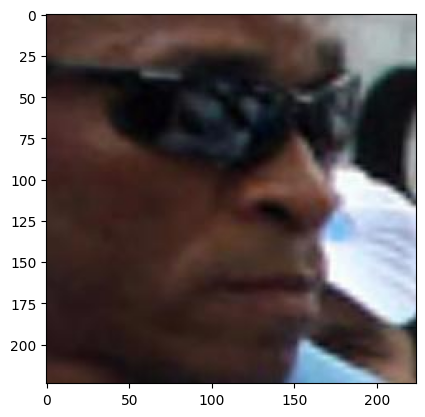

In [ ]:
image_path = "/content/my_datasets/fairface/fairface/val/VI/10752.jpg"
img = tf.keras.utils.load_img(
    image_path, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions[0])
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {predictions[0]}")
print(f"Predicted class name: {class_names[predicted_class]}")
plt.imshow(img)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class: 2
Class probabilities: [0.11144046 0.00145171 0.87711823 0.00671349 0.00327612]
Predicted class name: Latino_Hispanic


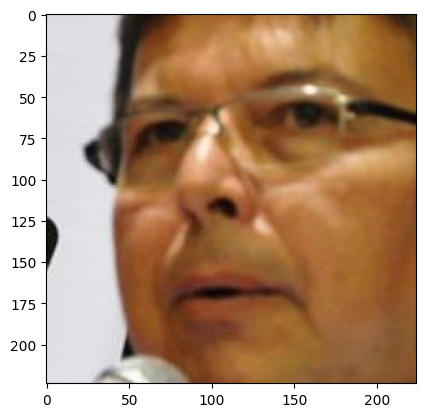

In [ ]:
image_path = "/content/my_datasets/fairface/fairface/val/IV/10341.jpg"  # Example image path
img = tf.keras.utils.load_img(
    image_path, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions[0])
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {predictions[0]}")
print(f"Predicted class name: {class_names[predicted_class]}")
plt.imshow(img)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class: 1
Class probabilities: [0.0366858  0.79998326 0.04676973 0.11280854 0.00375263]
Predicted class name: East Asian


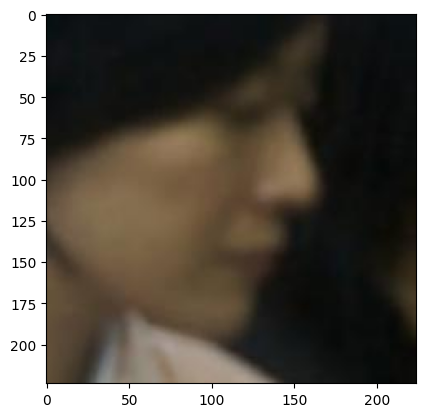

In [ ]:
image_path = "/content/my_datasets/fairface/fairface/val/III/10085.jpg"  # Example image path
img = tf.keras.utils.load_img(
    image_path, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions[0])
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {predictions[0]}")
print(f"Predicted class name: {class_names[predicted_class]}")
plt.imshow(img)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted class: 0
Class probabilities: [0.692477   0.00387136 0.2659335  0.03412949 0.00358865]
Predicted class name: White


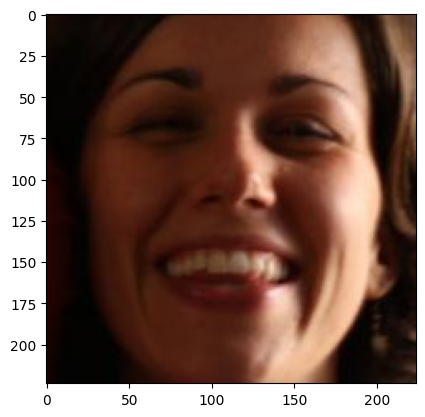

In [ ]:
image_path = "/content/my_datasets/fairface/fairface/val/I & II/10379.jpg"  # Example image path
img = tf.keras.utils.load_img(
    image_path, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions[0])
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {predictions[0]}")
print(f"Predicted class name: {class_names[predicted_class]}")
plt.imshow(img)
plt.show()